In [2]:
# importing necessary libraries and start a spark session
import numpy as np
import pandas as pd
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.246:7077") \
        .appName("mental_health_analysis")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores",2)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

spark_context = spark_session.sparkContext
# just show errors
spark_context.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/07 19:10:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# read the dataset from hdfs
data = spark_session.read.json("hdfs://192.168.2.142:9000/user/ubuntu/data/corpus-webis-tldr-17.json")
# print schema
# data.printSchema()

In [28]:
# show the first 10 rows
data.show(10)

+------------------+--------------------+--------------------+-----------+-------+--------------------+--------------------+------------+--------------------+-----------+--------+
|            author|                body|             content|content_len|     id|      normalizedBody|           subreddit|subreddit_id|             summary|summary_len|   title|
+------------------+--------------------+--------------------+-----------+-------+--------------------+--------------------+------------+--------------------+-----------+--------+
|  raysofdarkmatter|I think it should...|I think it should...|        178|c69al3r|I think it should...|                math|    t5_2qh0n|Shifting seasonal...|          8|    NULL|
|           Stork13|Art is about the ...|Art is about the ...|        148|c6a9nxd|Art is about the ...|               funny|    t5_2qh33|Personal opinions...|          4|    NULL|
|     Cloud_dreamer|Ask me what I thi...|Ask me what I thi...|         76|c6acx4l|Ask me what I thi.

In [29]:
# convert spark dataframe to Pandas dataframe to show the dataset in a better format
data_pandas = data.limit(10).toPandas()
display(data_pandas)

,author,body,content,content_len,id,normalizedBody,subreddit,subreddit_id,summary,summary_len,title
0,raysofdarkmatter,I think it should be fixed on either UTC stand...,I think it should be fixed on either UTC stand...,178,c69al3r,I think it should be fixed on either UTC stand...,math,t5_2qh0n,Shifting seasonal time is no longer worth it.,8,None
1,Stork13,Art is about the hardest thing to categorize i...,Art is about the hardest thing to categorize i...,148,c6a9nxd,Art is about the hardest thing to categorize i...,funny,t5_2qh33,Personal opinions 'n shit.,4,None
2,Cloud_dreamer,Ask me what I think about the Wall Street Jour...,Ask me what I think about the Wall Street Jour...,76,c6acx4l,Ask me what I think about the Wall Street Jour...,Borderlands,t5_2r8cd,insults and slack ass insight. \n Wall Street ...,73,None
3,NightlyReaper,"In Mechwarrior Online, I have begun to use a m...","In Mechwarrior Online, I have begun to use a m...",213,c8onqew,"In Mechwarrior Online, I have begun to use a m...",gamingpc,t5_2sq2y,"Yes, Joysticks in modern games have apparently...",19,None
4,NuffZetPand0ra,"You are talking about the Charsi imbue, right?...","You are talking about the Charsi imbue, right?...",404,c6acxvc,"You are talking about the Charsi imbue, right?...",Diablo,t5_2qore,Class only items dropped from high-lvl monsters.,7,D2 help?
5,beatlecreedcabaret,All but one of my nails were in the ballpark o...,All but one of my nails were in the ballpark o...,130,c6ahuc4,All but one of my nails were in the ballpark o...,RedditLaqueristas,t5_2se5q,OPI Nail Envy!,3,None
6,nobodysdiary,I could give a shit about turn by turn directi...,I could give a shit about turn by turn directi...,156,c6aggux,I could give a shit about turn by turn directi...,apple,t5_2qh1f,I don't drive like most people in major citi...,18,None
7,chrom_ed,"So you're saying ""try it, I might not mind los...","So you're saying ""try it, I might not mind los...",134,c6agxtv,"So you're saying ""try it, I might not mind los...",apple,t5_2qh1f,you don't seem to understand what's going on h...,9,None
8,gadzookfilms,I love this idea and most definitely want to h...,I love this idea and most definitely want to h...,126,c6asb7p,I love this idea and most definitely want to h...,RedditFilmsProduction,t5_2v33h,"How we make money? How we involve everyone, yo?",9,None
9,iamacannibal,Theres an entire small town under the lake by ...,Theres an entire small town under the lake by ...,181,c6aveyw,Theres an entire small town under the lake by ...,AbandonedPorn,t5_2sh6t,I'll try and get some similar shots from lake ...,25,None


In [30]:
# print total number of rows
print("The number of total rows of the dataset is: \t", data.count())
# print the number of different subreddits
print("The number of different subreddits is: \t", data.select("subreddit").distinct().count())

The number of total rows of the dataset is: 	 3848330


The number of different subreddits is: 	 29651


In [31]:
# show the top 20 subreddits
top_subreddits = data.groupBy('subreddit').count().orderBy('count', ascending=False)
top_subreddits.show(20)

+-------------------+------+
|          subreddit| count|
+-------------------+------+
|          AskReddit|589947|
|      relationships|352049|
|    leagueoflegends|109307|
|               tifu| 52219|
|relationship_advice| 50416|
|              trees| 47286|
|             gaming| 43851|
|            atheism| 43268|
|      AdviceAnimals| 40783|
|              funny| 40171|
|           politics| 36518|
|               pics| 35098|
|                sex| 28806|
|                WTF| 25781|
|  explainlikeimfive| 25482|
|      todayilearned| 25004|
|            Fitness| 22694|
|               IAmA| 22689|
|          worldnews| 22577|
|              DotA2| 22405|
+-------------------+------+
only showing top 20 rows



In [4]:
# take a subset of the data
subset_data = data.limit(100000)
subset_data.show(10)

+------------------+--------------------+--------------------+-----------+-------+--------------------+--------------------+------------+--------------------+-----------+--------+
|            author|                body|             content|content_len|     id|      normalizedBody|           subreddit|subreddit_id|             summary|summary_len|   title|
+------------------+--------------------+--------------------+-----------+-------+--------------------+--------------------+------------+--------------------+-----------+--------+
|  raysofdarkmatter|I think it should...|I think it should...|        178|c69al3r|I think it should...|                math|    t5_2qh0n|Shifting seasonal...|          8|    NULL|
|           Stork13|Art is about the ...|Art is about the ...|        148|c6a9nxd|Art is about the ...|               funny|    t5_2qh33|Personal opinions...|          4|    NULL|
|     Cloud_dreamer|Ask me what I thi...|Ask me what I thi...|         76|c6acx4l|Ask me what I thi.

In [33]:
subset_data.count()

100000

In [8]:
from pyspark.sql.functions import col

# defining keywords related to mental health, in tuple format
general_keywords = [
    'anxiety', 'panic', 'phobia', 
    'depression', 'bipolar', 'moodswings', 'mood_swings', 'mood swings'
    'schizophrenia', 'delusions', 'hallucinations',
    'anorexia', 'bulimia','binge_eating', 'addiction', 
    'obsessivecompulsivedisorder', 'obsessive_compulsive_disorder', 'obsessive compulsive disorder'
    'OCD', 'borderline', 'antisocial', 
    'narcissistic','PTSD', 'trauma', 'stress',
    'dissociative_identity', 'amnesia',
    'psychotic', 'depressive', 'suicide', 'suicidal'
    'mentalhealth', 'mental_health', 'mental health'
]

# mental_disorders = [
#     'anxiety', 'panic', 'phobia', 
#     'depression', 'bipolar', 'mood swings',
#     'schizophrenia', 'delusions', 'hallucinations',
#     'anorexia', 'bulimia', 'binge eating','addiction', 
#     'obsessive compulsive disorder', 'OCD', 'borderline personality', 'antisocial', 
#     'narcissistic','PTSD', 'trauma', 'stress',
#     'dissociative identity', 'dissociative_identity', 'amnesia',
#     'psychotic', 'depressive', 'suicide', 'suicidal'
#     'mentalhealth', 'mental_health',
# ]


In [15]:
from pyspark.sql.functions import lower, trim

# preprocess subreddit column
subset_data = subset_data.withColumn('subreddit', lower(trim(col('subreddit'))))

# Create a DataFrame from the list of general keywords
keywords_df = spark_session.createDataFrame([(k,) for k in general_keywords], ['keyword'])

# Make sure that the keywords are lowercased
keywords_df = keywords_df.withColumn('keyword', lower(col('keyword')))

# Count the occurrences of each subreddit keyword
# Ensure that the join condition is based on the normalized 'subreddit' column
keyword_counts_data = (
    subset_data
    .join(keywords_df, col('subreddit') == col('keyword'), 'right_outer')
    .groupBy('keyword')
    .count()
    .orderBy('count', ascending=False)
)

# Show the result
keyword_counts_data.show()

+--------------+-----+
|       keyword|count|
+--------------+-----+
|    depression|   89|
|       anxiety|   30|
|       bipolar|   26|
| schizophrenia|    3|
|           ocd|    3|
|          ptsd|    3|
|    moodswings|    1|
|        phobia|    1|
|   mood_swings|    1|
|         panic|    1|
|       bulimia|    1|
|      anorexia|    1|
|hallucinations|    1|
|     delusions|    1|
|     addiction|    1|
|  binge_eating|    1|
|       suicide|    1|
|        trauma|    1|
|     psychotic|    1|
|        stress|    1|
+--------------+-----+
only showing top 20 rows



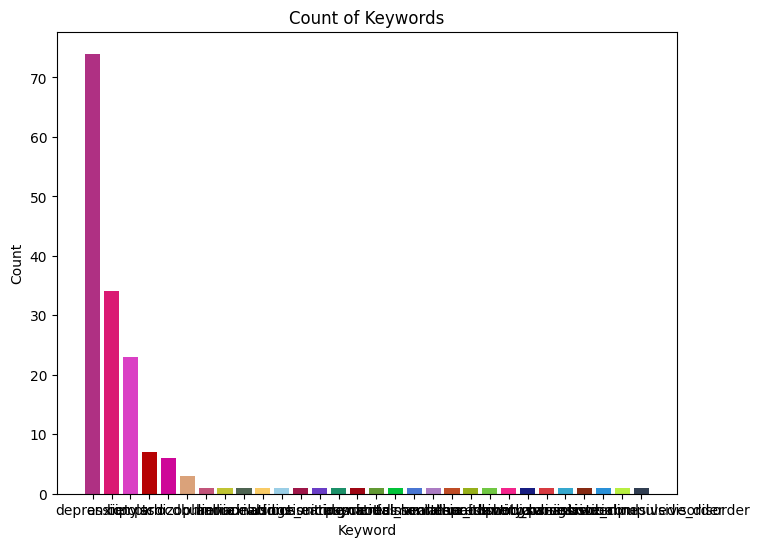

In [20]:
import matplotlib.pyplot as plt

# convert PySpark dataframe to pandas datafraame
keyword_counts_pandas = keyword_counts_data.toPandas()

total_keywords = len(keyword_counts_pandas)
# generate random colors for each keyword
colors_list = np.random.rand(total_keywords, 3)

plt.figure(figsize=(18, 6))
plt.bar(keyword_counts_pandas['keyword'], keyword_counts_pandas['count'], color=colors_list)
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Count of Keywords')
plt.xticks(rotation=90)
plt.show()

In [19]:
broadcasted_keywords = spark_session.sparkContext.broadcast(general_keywords)

def filter_keywords(content, keywords):
    return [keyword for keyword in keywords if keyword in content]

# Register the UDF with Spark
filter_keywords_udf = udf(lambda content: filter_keywords(content, broadcasted_keywords.value), ArrayType(StringType()))

# Apply the UDF to create the keywords_present column
subset_data = subset_data.withColumn("keywords_present", filter_keywords_udf(col('content')))

# Explode the keywords_present array into a new row for each keyword present per content
subset_data = subset_data.withColumn("keyword", explode("keywords_present"))

# Count the occurrences of each keyword
keyword_counts_df = subset_data.groupBy('keyword').count()

# Show the results
keyword_counts_df.show(truncate=False)

+--------------+-----+
|keyword       |count|
+--------------+-----+
|panic         |974  |
|trauma        |359  |
|stress        |1594 |
|anorexia      |27   |
|bulimia       |11   |
|depression    |987  |
|suicide       |594  |
|anxiety       |672  |
|phobia        |165  |
|bipolar       |141  |
|addiction     |364  |
|delusions     |46   |
|hallucinations|71   |
|amnesia       |46   |
|borderline    |165  |
|schizophrenia |58   |
|psychotic     |99   |
|depressive    |70   |
|antisocial    |37   |
|narcissistic  |56   |
+--------------+-----+
only showing top 20 rows



           keyword  count
0            panic    984
1           trauma    350
2           stress   1596
3         anorexia     27
4          bulimia     10
5       depression    978
6          suicide    572
7          anxiety    711
8           phobia    177
9          bipolar    121
10       addiction    326
11       delusions     45
12  hallucinations     84
13         amnesia     47
14      borderline    157
15   schizophrenia     50
16       psychotic     96
17      depressive     65
18      antisocial     41
19    narcissistic     43
20      moodswings      1


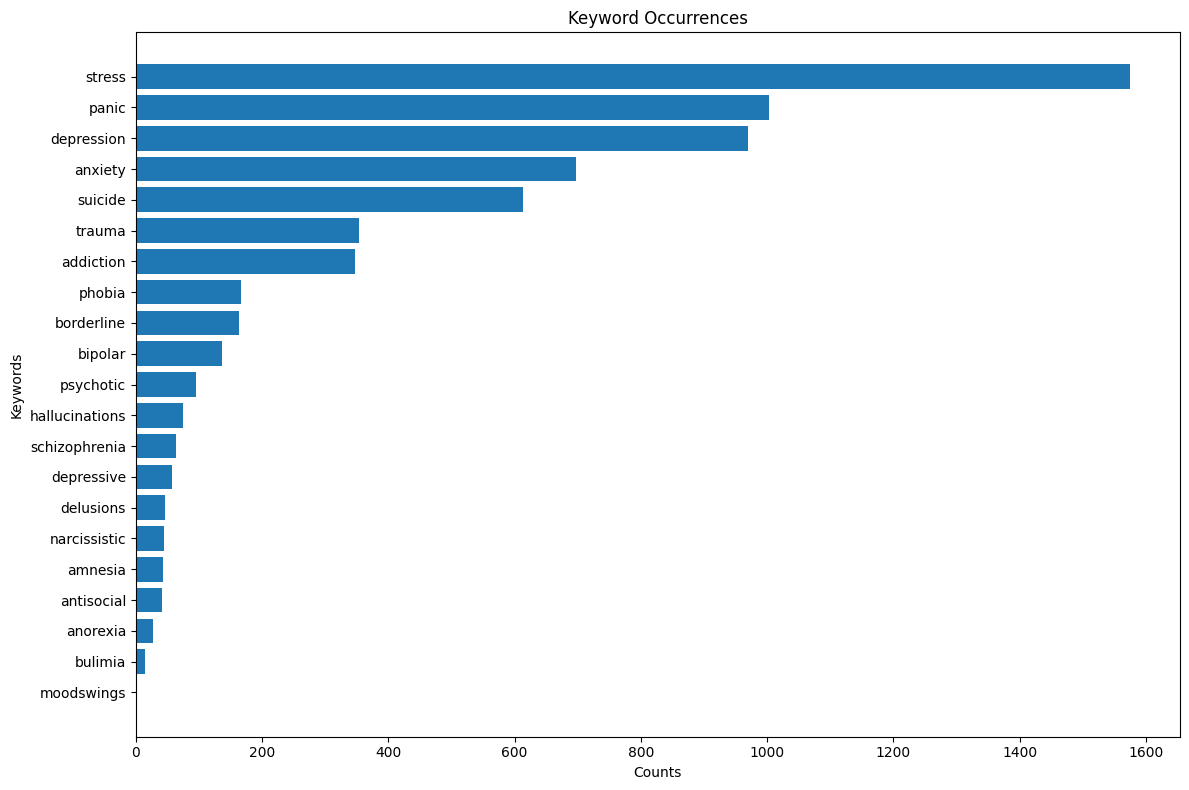

In [22]:
# Sort the DataFrame by count in descending order
keyword_counts_df = keyword_counts_df.orderBy(col('count').desc())

# Collect the data to the driver node
keyword_counts_data = keyword_counts_df.collect()

# Now keyword_counts_data is a list of Rows, you can convert it to a dictionary or directly to lists to plot it.
keywords = [row['keyword'] for row in keyword_counts_data]
counts = [row['count'] for row in keyword_counts_data]

# Use matplotlib to plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.barh(keywords[::-1], counts[::-1])  # Reverse the lists to have the largest count at the top
plt.xlabel('Counts')
plt.ylabel('Keywords')
plt.title('Keyword Occurrences')
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()


In [12]:
from pyspark.sql.functions import trim, expr

# Preprocess the content column (convert to lowercase and trim whitespace)
subset_data = subset_data.withColumn('content', lower(trim(col('content'))))

# Combine all keywords into a single expression that checks for their presence
# This creates a boolean column for each keyword indicating its presence in the content
for keyword in general_keywords:
    normalized_keyword = keyword.replace(" ", "_")  # Replace spaces with underscores for column naming
    subset_data = subset_data.withColumn(normalized_keyword, expr(f"CONTAINS(content, '{keyword}')"))

# Aggregate the results by summing the boolean flags (true=1, false=0) for each keyword
# This avoids the need to scan the dataset multiple times
aggregation_exprs = [sum(col(keyword.replace(" ", "_")).cast("integer")).alias(keyword.replace(" ", "_")) for keyword in general_keywords]
keyword_counts_df = subset_data.agg(*aggregation_exprs)

keyword_counts_df.show(truncate=False)

# Optionally convert to Pandas DataFrame for easier handling/display
keyword_counts_pandas = keyword_counts_df.toPandas()
print(keyword_counts_pandas)


+-------+-----+------+----------+-------+----------+-----------+-------------+---------+--------------+--------+-------+------------+---------+---------------------------+-----------------------------+---+----------+----------+------------+----+------+------+---------------------+-------+---------+----------+-------+--------------------+-------------+
|anxiety|panic|phobia|depression|bipolar|moodswings|mood_swings|schizophrenia|delusions|hallucinations|anorexia|bulimia|binge_eating|addiction|obsessivecompulsivedisorder|obsessive_compulsive_disorder|OCD|borderline|antisocial|narcissistic|PTSD|trauma|stress|dissociative_identity|amnesia|psychotic|depressive|suicide|suicidalmentalhealth|mental_health|
+-------+-----+------+----------+-------+----------+-----------+-------------+---------+--------------+--------+-------+------------+---------+---------------------------+-----------------------------+---+----------+----------+------------+----+------+------+---------------------+-------+---

   anxiety  panic  phobia  depression  bipolar  moodswings  mood_swings  \
0      699    984     177         984      114           0            0   

   schizophrenia  delusions  hallucinations  ...  PTSD  trauma  stress  \
0             67         46              92  ...     0     381    1598   

   dissociative_identity  amnesia  psychotic  depressive  suicide  \
0                      0       34         98          61      582   

   suicidalmentalhealth  mental_health  
0                     0              0  

[1 rows x 30 columns]


In [38]:
# # convert PySpark dataframe to Pandas dataframe
# content_counts_pandas = content_counts_data.toPandas()

# plt.figure(figsize=(10, 6))
# plt.bar(content_counts_pandas['content_word'], content_counts_pandas['count'], color=colors_list)
# plt.xlabel('Keyword')
# plt.ylabel('Count')
# plt.title('Count of Keywords')
# plt.xticks(rotation=90)
# plt.show()